## Grokking Hacking 4

In [1]:
import os
import sys
from pathlib import Path

IN_COLAB = "google.colab" in sys.modules

chapter = "chapter1_transformer_interp"
repo = "ARENA_3.0"
branch = "main"

# Install dependencies
try:
    import transformer_lens
except:
    %pip install transformer_lens==2.11.0

# Get root directory, handling 3 different cases: (1) Colab, (2) notebook not in ARENA repo, (3) notebook in ARENA repo
root = (
    "/content"
    if IN_COLAB
    else "/root"
    if repo not in os.getcwd()
    else str(next(p for p in Path.cwd().parents if p.name == repo))
)

if Path(root).exists() and not Path(f"{root}/{chapter}").exists():
    if not IN_COLAB:
        !sudo apt-get install unzip
        %pip install jupyter ipython --upgrade

    if not os.path.exists(f"{root}/{chapter}"):
        !wget -P {root} https://github.com/callummcdougall/ARENA_3.0/archive/refs/heads/{branch}.zip
        !unzip {root}/{branch}.zip '{repo}-{branch}/{chapter}/exercises/*' -d {root}
        !mv {root}/{repo}-{branch}/{chapter} {root}/{chapter}
        !rm {root}/{branch}.zip
        !rmdir {root}/{repo}-{branch}

if f"{root}/{chapter}/exercises" not in sys.path:
    sys.path.append(f"{root}/{chapter}/exercises")

os.chdir(f"{root}/{chapter}/exercises")

In [2]:
import os
import sys
from functools import partial
from pathlib import Path

import einops
import numpy as np
import torch as t
import torch.nn.functional as F
from huggingface_hub import hf_hub_download
from jaxtyping import Float
from torch import Tensor
from tqdm import tqdm
from transformer_lens import HookedTransformer, HookedTransformerConfig
from transformer_lens.utils import to_numpy
import matplotlib.pyplot as plt
from ipywidgets import interact

# Make sure exercises are in the path
chapter = "chapter1_transformer_interp"
section = "part52_grokking_and_modular_arithmetic"
root_dir = next(p for p in Path.cwd().parents if (p / chapter).exists())
exercises_dir = root_dir / chapter / "exercises"
section_dir = exercises_dir / section

grokking_root = section_dir / "Grokking"
saved_runs_root = grokking_root / "saved_runs"

import part52_grokking_and_modular_arithmetic.tests as tests
import part52_grokking_and_modular_arithmetic.utils as utils

device = t.device("cuda" if t.cuda.is_available() else "cpu")

t.set_grad_enabled(False)

MAIN = __name__ == "__main__"

In [3]:
p = 113

cfg = HookedTransformerConfig(
    n_layers=1,
    d_vocab=p + 1,
    d_model=128,
    d_mlp=4 * 128,
    n_heads=4,
    d_head=128 // 4,
    n_ctx=3,
    act_fn="relu",
    normalization_type=None,
    device=device,
)

model = HookedTransformer(cfg)

In [4]:
REPO_ID = "callummcdougall/grokking_full_run_data"
FILENAME = "full_run_data.pth"

local_dir = hf_hub_download(repo_id=REPO_ID, filename=FILENAME)

full_run_data = t.load(local_dir, weights_only=True)
state_dict = full_run_data["state_dicts"][400]

model = utils.load_in_state_dict(model, state_dict)

In [5]:
# Get all data and labels, and cache activations
all_data = t.tensor([(i, j, p) for i in range(p) for j in range(p)]).to(device)
labels = t.tensor([utils.target_fn(i, j) for i, j, _ in all_data]).to(device)
original_logits, cache = model.run_with_cache(all_data)

# Final position only, also remove the logits for `=`
original_logits = original_logits[:, -1, :-1]

# Get cross entropy loss
original_loss = utils.cross_entropy_high_precision(original_logits, labels)
print(f"Original loss: {original_loss.item():.3e}")

Original loss: 2.412e-07


In [6]:
for k in cache:
    print(k, cache[k].shape)

hook_embed torch.Size([12769, 3, 128])
hook_pos_embed torch.Size([12769, 3, 128])
blocks.0.hook_resid_pre torch.Size([12769, 3, 128])
blocks.0.attn.hook_q torch.Size([12769, 3, 4, 32])
blocks.0.attn.hook_k torch.Size([12769, 3, 4, 32])
blocks.0.attn.hook_v torch.Size([12769, 3, 4, 32])
blocks.0.attn.hook_attn_scores torch.Size([12769, 4, 3, 3])
blocks.0.attn.hook_pattern torch.Size([12769, 4, 3, 3])
blocks.0.attn.hook_z torch.Size([12769, 3, 4, 32])
blocks.0.hook_attn_out torch.Size([12769, 3, 128])
blocks.0.hook_resid_mid torch.Size([12769, 3, 128])
blocks.0.mlp.hook_pre torch.Size([12769, 3, 512])
blocks.0.mlp.hook_post torch.Size([12769, 3, 512])
blocks.0.hook_mlp_out torch.Size([12769, 3, 128])
blocks.0.hook_resid_post torch.Size([12769, 3, 128])


In [7]:
# Helper variables
W_O = model.W_O[0]
W_K = model.W_K[0]
W_Q = model.W_Q[0]
W_V = model.W_V[0]
W_in = model.W_in[0]
W_out = model.W_out[0]
W_pos = model.W_pos
W_E = model.W_E[:-1]
final_pos_resid_initial = model.W_E[-1] + W_pos[2]
W_U = model.W_U[:, :-1]

print("W_O  ", tuple(W_O.shape))
print("W_K  ", tuple(W_K.shape))
print("W_Q  ", tuple(W_Q.shape))
print("W_V  ", tuple(W_V.shape))
print("W_in ", tuple(W_in.shape))
print("W_out", tuple(W_out.shape))
print("W_pos", tuple(W_pos.shape))
print("W_E  ", tuple(W_E.shape))
print("W_U  ", tuple(W_U.shape))

W_O   (4, 32, 128)
W_K   (4, 128, 32)
W_Q   (4, 128, 32)
W_V   (4, 128, 32)
W_in  (128, 512)
W_out (512, 128)
W_pos (3, 128)
W_E   (113, 128)
W_U   (128, 113)


In [8]:
m=cache['blocks.0.mlp.hook_pre'].detach().cpu().numpy()
mr = einops.rearrange(cache['blocks.0.mlp.hook_pre'], "(x y) ... -> x y ...", x=p).detach().cpu().numpy()

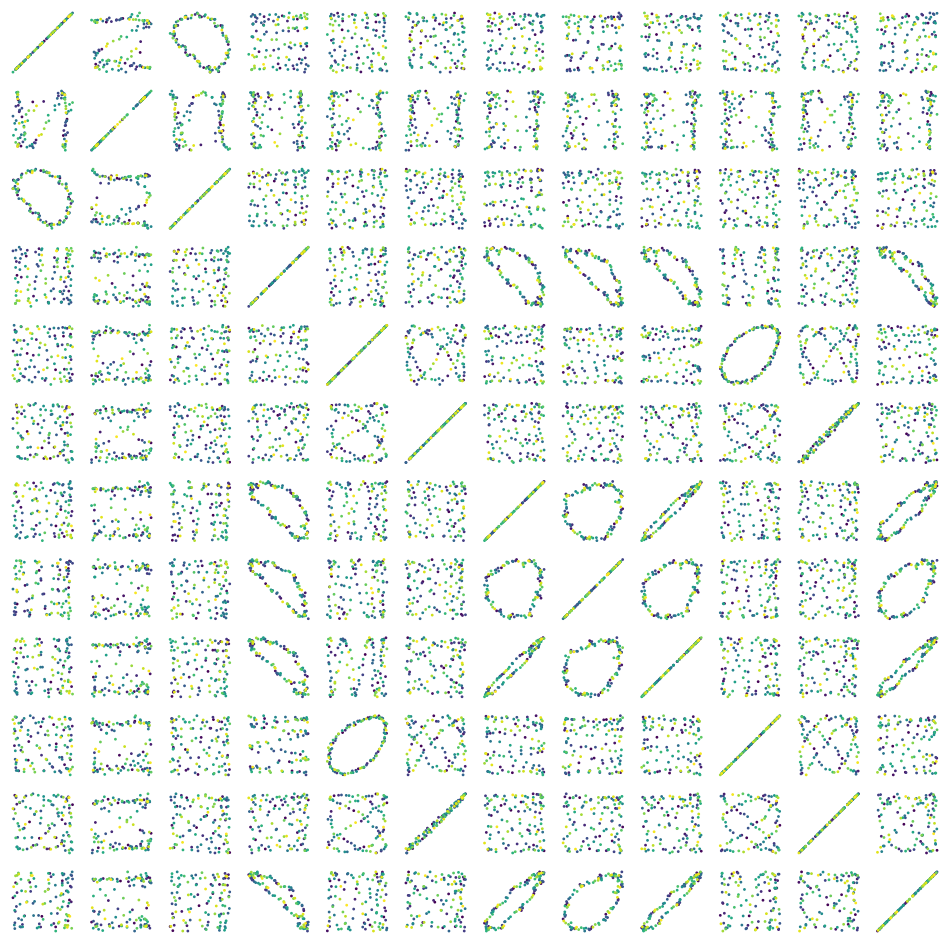

In [9]:
fig=plt.figure(0, (12,12))
for i in range(12):
    for j in range(12):
        fig.add_subplot(12,12, 12*i+j+1)
        plt.scatter(mr[:113, 0, 2, i], mr[:113, 0, 2, j], c=range(113), s=1)
        plt.axis('off')

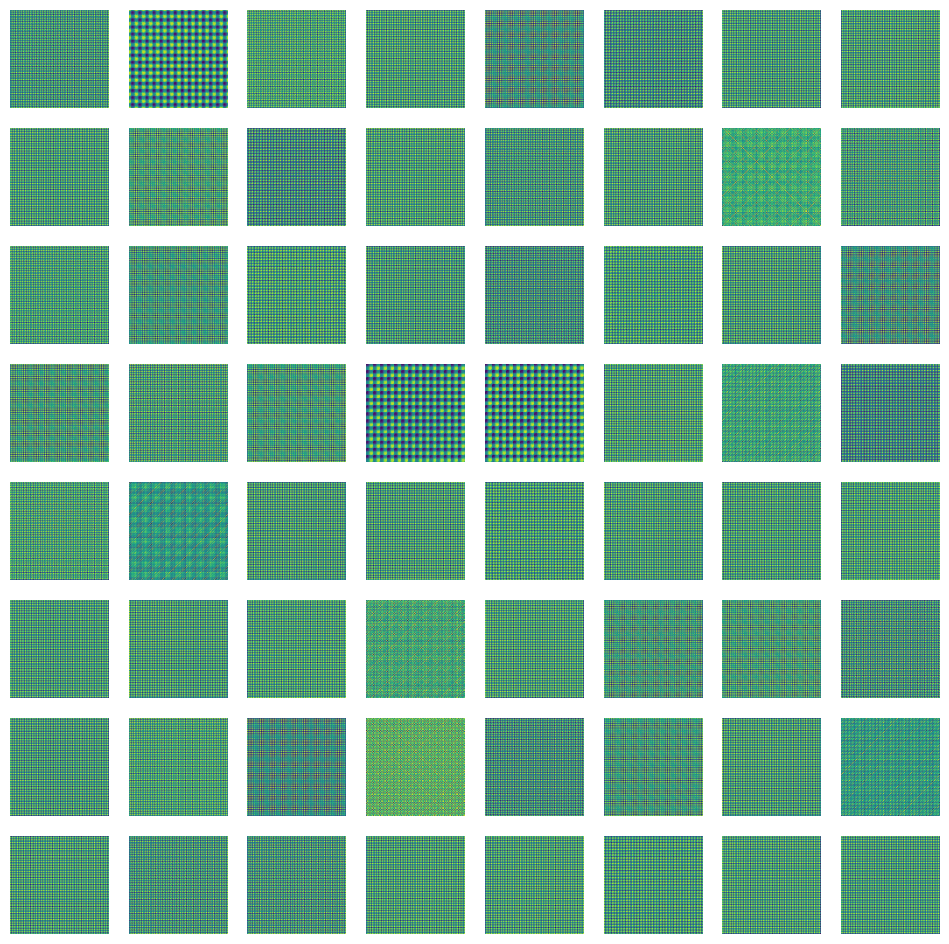

In [10]:
fig=plt.figure(0, (12,12))
for i in range(64):
    fig.add_subplot(8,8, i+1)
    plt.imshow(mr[:,:,2,i])
    plt.axis('off')

In [11]:
# fig=plt.figure(0, (12,12))
# for i in range(64):
#     fig.add_subplot(8,8, i+1)
#     plt.imshow(mr[:,:,2,64+i])
#     plt.axis('off')

In [12]:
def fourier_approx_2d(x, num_freqs):
    """
    x: 2D real array, shape (Nx, Ny)
    num_freqs: number of Fourier coefficients to keep (by magnitude)

    Returns:
        F_sparse: sparse 2D Fourier spectrum (complex, same shape as x)
        x_hat: real reconstruction from the sparse spectrum
    """
    # 2D FFT
    F = np.fft.fft2(x)
    
    # Flatten and sort coefficients by magnitude (descending)
    flat = F.ravel()
    idx_sorted = np.argsort(np.abs(flat))[::-1]
    
    # Indices of top num_freqs coefficients
    keep_idx = idx_sorted[:num_freqs]
    
    # Build sparse spectrum
    flat_sparse = np.zeros_like(flat, dtype=complex)
    flat_sparse[keep_idx] = flat[keep_idx]
    F_sparse = flat_sparse.reshape(F.shape)
    
    # Reconstruct (take real part to remove tiny numerical imaginary noise)
    x_hat = np.fft.ifft2(F_sparse).real
    
    return F_sparse, x_hat

def spectrum_to_terms(F_sparse):
    """
    Turn a sparse spectrum into a list of (kx, ky, amplitude, phase) terms.
    Only nonzero entries are returned.
    """
    Nx, Ny = F_sparse.shape
    terms = []
    
    for (kx, ky), c in np.ndenumerate(F_sparse):
        if c == 0:
            continue
        amp = np.abs(c) / (Nx * Ny)   # matches np.fft normalization
        phase = np.angle(c)
        terms.append({
            "kx": kx,
            "ky": ky,
            "amplitude": amp,
            "phase": phase
        })
    
    return terms

def generate_python_reconstructor(terms, Nx, Ny, func_name="recon_func", decimals=4):
    """
    Generate a Python function as a string that reconstructs the signal
    using explicit cosine terms from a sparse Fourier representation.
    """

    lines = []
    # lines.append("import numpy as np\n")
    lines.append(f"def {func_name}(i, j):")
    
    if len(terms) == 0:
        lines.append("    return 0.0")
        return "\n".join(lines)

    lines.append("    return (")

    for t in terms:
        kx, ky = t["kx"], t["ky"]
        A = round(t["amplitude"], decimals)
        phi = round(t["phase"], decimals)

        if A == 0:
            continue

        # One cosine term
        line = (
            f"        {A} * np.cos(2*np.pi*((({kx}*i)/a{Nx}) + "
            f"(({ky}*j)/{Ny})) + {phi}) +"
        )
        lines.append(line)

    # Remove trailing '+'
    lines[-1] = lines[-1].rstrip(" +")

    lines.append("    )")

    return "\n".join(lines)

# def reconstruction_error(x, x_hat, remove_mean=True):
#     if remove_mean:
#         x=x-x.mean(); x_hat=x_hat-x_hat.mean()
#     diff = x - x_hat
#     mse = np.mean(diff**2)
#     rel_l2 = np.linalg.norm(diff) / np.linalg.norm(x)
#     return mse, rel_l2

In [13]:
m=cache['blocks.0.mlp.hook_pre'].detach().cpu().numpy()
mr = einops.rearrange(cache['blocks.0.mlp.hook_pre'], "(x y) ... -> x y ...", x=p).detach().cpu().numpy()

# m=cache['blocks.0.mlp.hook_post'].detach().cpu().numpy()
# mr = einops.rearrange(cache['blocks.0.mlp.hook_post'], "(x y) ... -> x y ...", x=p).detach().cpu().numpy()

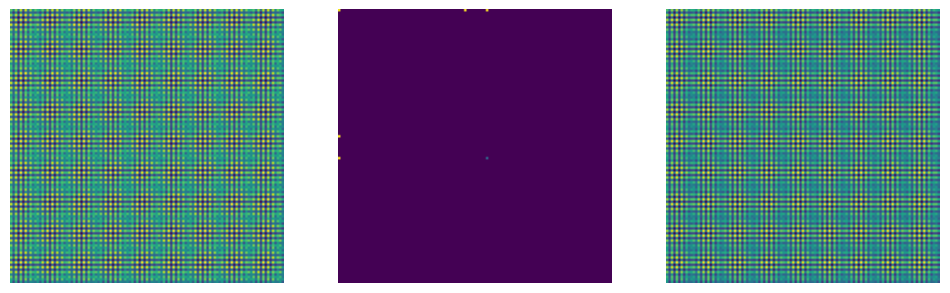

In [14]:
neuron_idx=4
F_sparse, x_hat = fourier_approx_2d(mr[:,:,2,neuron_idx], num_freqs=6)

fig=plt.figure(0, (12, 6))
fig.add_subplot(1,3,1); plt.imshow(mr[:,:,2,neuron_idx]); plt.axis('off')
fig.add_subplot(1,3,2); plt.imshow(np.abs(F_sparse));  plt.axis('off')
fig.add_subplot(1,3,3); plt.imshow(x_hat); plt.axis('off');

In [15]:
# mr_zero_mean=mr[:,:,2,neuron_idx]-mr[:,:,2,neuron_idx].mean()
# np.linalg.norm(mr_zero_mean-x_hat)/np.linalg.norm(mr_zero_mean) #Eh still kinda big -> seems a little fishy. Looks good visually tho -> ignoreing for now. 

# plt.plot(mr[:,10,2,neuron_idx])
# plt.plot(x_hat[:,10])

In [16]:
terms=spectrum_to_terms(F_sparse)
c=generate_python_reconstructor(terms, 113, 113)
print(c)

def recon_func(i, j):
    return (
        0.8729 * np.cos(2*np.pi*(((0*i)/113) + ((0*j)/113)) + -0.0) +
        0.8868 * np.cos(2*np.pi*(((0*i)/113) + ((52*j)/113)) + 0.9769) +
        0.8868 * np.cos(2*np.pi*(((0*i)/113) + ((61*j)/113)) + -0.9769) +
        0.8879 * np.cos(2*np.pi*(((52*i)/113) + ((0*j)/113)) + 0.9765) +
        0.8879 * np.cos(2*np.pi*(((61*i)/113) + ((0*j)/113)) + -0.9765) +
        0.3025 * np.cos(2*np.pi*(((61*i)/113) + ((61*j)/113)) + -1.8906)
    )


In [17]:
def recon_func(i, j):
    return (
        # 0.8729 * np.cos(2*np.pi*(((0*i)/113) + ((0*j)/113)) + -0.0) +
        # 0.8868 * np.cos(2*np.pi*(((0*i)/113) + ((52*j)/113)) + 0.9769) +
        # 0.8868 * np.cos(2*np.pi*(((0*i)/113) + ((61*j)/113)) + -0.9769) +
        # 0.8879 * np.cos(2*np.pi*(((52*i)/113) + ((0*j)/113)) + 0.9765) +
        # 0.8879 * np.cos(2*np.pi*(((61*i)/113) + ((0*j)/113)) + -0.9765) +
        0.3025 * np.cos(2*np.pi*(((61*i)/113) + ((61*j)/113)) + -1.8906) #Only look at cross term for a minute!
    )

(-0.5, 112.5, 112.5, -0.5)

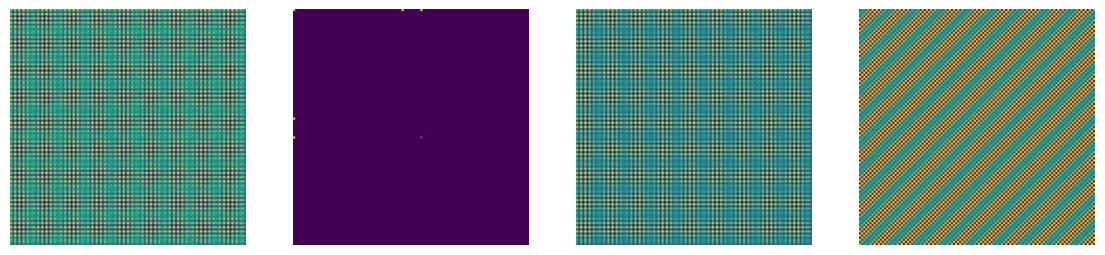

In [18]:
manual_recon=np.zeros((p,p))

for i in range(p):
    for j in range(p):
        manual_recon[i, j] = recon_func(i,j)

fig=plt.figure(0, (14, 6))
fig.add_subplot(1,4,1); plt.imshow(mr[:,:,2,neuron_idx]); plt.axis('off')
fig.add_subplot(1,4,2); plt.imshow(np.abs(F_sparse)); plt.axis('off')
fig.add_subplot(1,4,3); plt.imshow(x_hat); plt.axis('off')
fig.add_subplot(1,4,4); plt.imshow(manual_recon); plt.axis('off')

- Ok inching along here.
- How does the embedding, attention, and first half of the MLP compute these functions? (Both primary and cross terms?)
    - Does the functional representation help?
- Neels paper says it's from using these trig identities. Can I make thie visually apparent somehow? 

In [19]:
# Helper variables
W_O = model.W_O[0]
W_K = model.W_K[0]
W_Q = model.W_Q[0]
W_V = model.W_V[0]
W_in = model.W_in[0]
W_out = model.W_out[0]
W_pos = model.W_pos
W_E = model.W_E[:-1]
final_pos_resid_initial = model.W_E[-1] + W_pos[2]
W_U = model.W_U[:, :-1]

#Functional Form
W_logit = W_out @ W_U

W_OV = W_V @ W_O
W_neur = W_E @ W_OV @ W_in

W_QK = W_Q @ W_K.transpose(-1, -2)
W_attn = final_pos_resid_initial @ W_QK @ W_E.T / (cfg.d_head**0.5)

In [20]:
W_E.shape

torch.Size([113, 128])

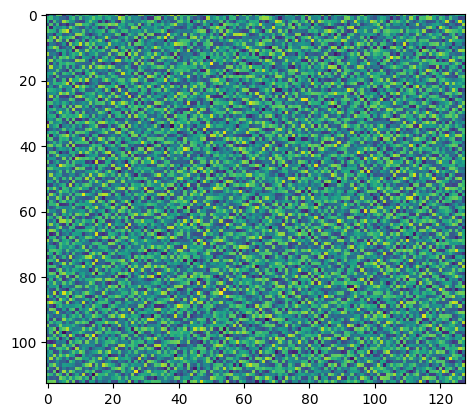

In [21]:
plt.imshow(W_E.detach().cpu().numpy())

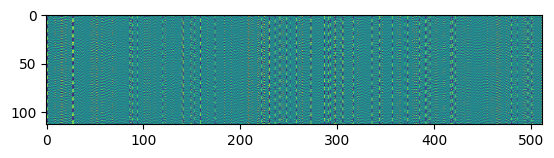

In [22]:
plt.imshow(W_neur[1].detach().cpu().numpy())

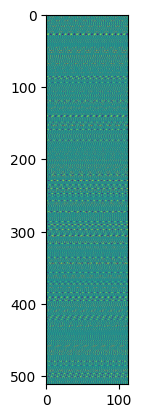

In [23]:
plt.imshow(W_logit.detach().cpu().numpy())

In [24]:
W_logit.shape, W_neur.shape, W_attn.shape

(torch.Size([512, 113]), torch.Size([4, 113, 512]), torch.Size([4, 113]))

- Ok, so the functional form seems like a nice place to start as far as "working upstream".
- I can decompose back into OG setup if needed.
- What I dont' see in the notebook however is like "replacing the model with the functional form" and showing that it still works.
- I feel like I probabl should do that? I'll need to move data through the functional form no matter what right? 

In [25]:
W_neur.shape

torch.Size([4, 113, 512])

In [26]:
all_data.shape

torch.Size([12769, 3])

In [27]:
m = all_data[:, 0]          # (N,)
n = all_data[:, 1]          # (N,)

t0 = F.one_hot(m, num_classes=p).float()   # (N, p)
t1 = F.one_hot(n, num_classes=p).float()   # (N, p)

# ----- 2. Compute alpha per head: α^h = σ(W_attn^h (t0 - t1)) -----
# diff: (N, p)
diff = t0 - t1

# W_attn: (n_heads, p)
# diff @ W_attn.T → (N, n_heads)
alpha = t.sigmoid(diff @ W_attn.T)         # (N, n_heads)

# For broadcasting later: (N, n_heads, 1)
alpha = alpha.unsqueeze(-1)

# ----- 3. Mix tokens per head: α^h t0 + (1-α^h) t1 -----
# Expand t0, t1 to (N, 1, p) to broadcast across heads
t0_exp = t0.unsqueeze(1)                   # (N, 1, p)
t1_exp = t1.unsqueeze(1)                   # (N, 1, p)

# token_mix: (N, n_heads, p)
token_mix = alpha * t0_exp + (1.0 - alpha) * t1_exp

# ----- 4. Map token_mix through W_neur -----
# W_neur: (n_heads, p, d_mlp)
# We want: (N, n_heads, d_mlp)
#
# Using einsum:
#  'nhp, hpd -> nhd'
neur_acts = t.einsum("nhp,hpd->nhd", token_mix, W_neur)  # (N, n_heads, d_mlp)

# Sum over heads: (N, d_mlp)
pre_mlp = neur_acts.sum(dim=1)

# ----- 5. ReLU, then logit projection -----
hidden = F.relu(pre_mlp)                  # (N, d_mlp)
logits = hidden @ W_logit                # (N, p)

In [28]:
t0.shape

torch.Size([12769, 113])

In [29]:
alpha.shape

torch.Size([12769, 4, 1])

In [30]:
neur_acts.shape

torch.Size([12769, 4, 512])

In [32]:
hidden.shape

torch.Size([12769, 512])

In [31]:
for i in range(500, 520):
    print(all_data[i, :], logits[i].argmax())

tensor([  4,  48, 113], device='cuda:0') tensor(52, device='cuda:0')
tensor([  4,  49, 113], device='cuda:0') tensor(53, device='cuda:0')
tensor([  4,  50, 113], device='cuda:0') tensor(54, device='cuda:0')
tensor([  4,  51, 113], device='cuda:0') tensor(55, device='cuda:0')
tensor([  4,  52, 113], device='cuda:0') tensor(34, device='cuda:0')
tensor([  4,  53, 113], device='cuda:0') tensor(57, device='cuda:0')
tensor([  4,  54, 113], device='cuda:0') tensor(58, device='cuda:0')
tensor([  4,  55, 113], device='cuda:0') tensor(18, device='cuda:0')
tensor([  4,  56, 113], device='cuda:0') tensor(60, device='cuda:0')
tensor([  4,  57, 113], device='cuda:0') tensor(61, device='cuda:0')
tensor([  4,  58, 113], device='cuda:0') tensor(79, device='cuda:0')
tensor([  4,  59, 113], device='cuda:0') tensor(63, device='cuda:0')
tensor([  4,  60, 113], device='cuda:0') tensor(64, device='cuda:0')
tensor([  4,  61, 113], device='cuda:0') tensor(106, device='cuda:0')
tensor([  4,  62, 113], device='c

In [25]:
alpha.shape

torch.Size([12769, 4, 1])

In [26]:
alpha[0]

tensor([[0.5000],
        [0.5000],
        [0.5000],
        [0.5000]], device='cuda:0')

In [27]:
token_mix.shape

torch.Size([12769, 4, 113])

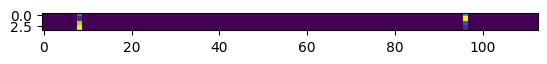

In [28]:
plt.imshow(token_mix[1000].detach().cpu().numpy())

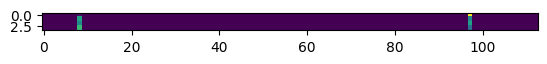

In [29]:
plt.imshow(token_mix[1001].detach().cpu().numpy())

In [30]:
W_neur.shape

torch.Size([4, 113, 512])

In [31]:
neur_acts.shape

torch.Size([12769, 4, 512])

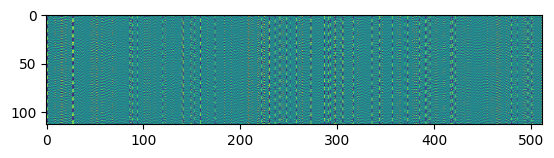

In [32]:
plt.imshow(W_neur[1].detach().cpu().numpy())

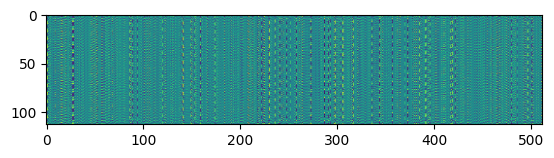

In [33]:
plt.imshow(neur_acts[:p, 1, :].detach().cpu().numpy()) #WOah super variable across heads - this is only 0+x tho

Looks a alot like the weights, which I think makes sense! Might vary as I move through more inputs. 

In [34]:
pre_mlp.shape

torch.Size([12769, 512])

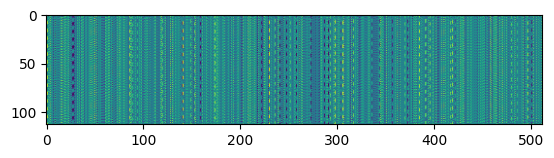

In [53]:
plt.imshow(pre_mlp[:p, :].detach().cpu().numpy()) 

- Ok yeah so nice frequenc-y behavior makes it through sum.
- Ok so from here it's just ReLu then final matrix multiply -> damn that's pretty crazy.
- Can I find clean geometric clcoks amongst these activations I wonder.
- It's almost like inputs are turning more on/off different columns -> does that kinda track?

In [54]:
hidden.shape

torch.Size([12769, 512])

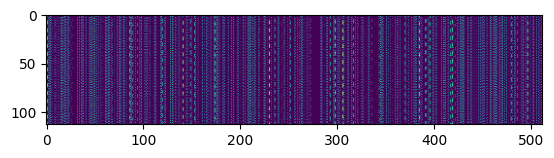

In [56]:
plt.imshow(hidden[:p, :].detach().cpu().numpy()) 

In [57]:
logits.shape

torch.Size([12769, 113])

In [58]:
W_logit.shape

torch.Size([512, 113])

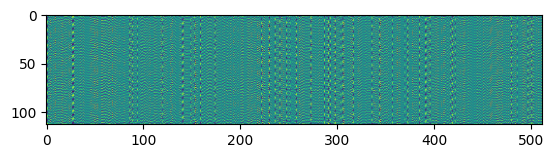

In [61]:
plt.imshow(W_logit.detach().cpu().numpy().T)

Everything is starting to look the same lol. 

----

In [38]:
t0 = F.one_hot(all_data[:, 0], p+1).float()  # [12769, 114]
t1 = F.one_hot(all_data[:, 1], p+1).float()  # [12769, 114]
t2 = F.one_hot(all_data[:, 2], p+1).float()  # [12769, 114]

t0_reduced = t0[:, :-1]  # [12769, 113]
t1_reduced = t1[:, :-1]  # [12769, 113]

n_heads = W_attn.shape[0]
attention_diff = t0_reduced - t1_reduced  # [12769, 113]

attn_logits = attention_diff @ W_attn.T  # [12769, 4]
alpha = t.sigmoid(attn_logits)  # [12769, 4]

alpha_expanded = alpha.unsqueeze(2)  # [12769, 4, 1]
weighted_embeddings = (alpha_expanded * t0_reduced.unsqueeze(1) + 
                       (1 - alpha_expanded) * t1_reduced.unsqueeze(1))

neuron_acts = t.einsum('bhp,hpd->bd', weighted_embeddings, W_neur)
neuron_acts = F.relu(neuron_acts)  # [12769, 512]
logits = neuron_acts @ W_logit  # [12769, 113]

In [39]:
logits.shape

torch.Size([12769, 113])

In [40]:
for i in range(500, 550):
    print(all_data[i, :], logits[i].argmax())

tensor([  4,  48, 113], device='cuda:0') tensor(52, device='cuda:0')
tensor([  4,  49, 113], device='cuda:0') tensor(53, device='cuda:0')
tensor([  4,  50, 113], device='cuda:0') tensor(54, device='cuda:0')
tensor([  4,  51, 113], device='cuda:0') tensor(55, device='cuda:0')
tensor([  4,  52, 113], device='cuda:0') tensor(34, device='cuda:0')
tensor([  4,  53, 113], device='cuda:0') tensor(57, device='cuda:0')
tensor([  4,  54, 113], device='cuda:0') tensor(58, device='cuda:0')
tensor([  4,  55, 113], device='cuda:0') tensor(18, device='cuda:0')
tensor([  4,  56, 113], device='cuda:0') tensor(60, device='cuda:0')
tensor([  4,  57, 113], device='cuda:0') tensor(61, device='cuda:0')
tensor([  4,  58, 113], device='cuda:0') tensor(79, device='cuda:0')
tensor([  4,  59, 113], device='cuda:0') tensor(63, device='cuda:0')
tensor([  4,  60, 113], device='cuda:0') tensor(64, device='cuda:0')
tensor([  4,  61, 113], device='cuda:0') tensor(106, device='cuda:0')
tensor([  4,  62, 113], device='c

In [41]:
attn_logits.shape

torch.Size([12769, 4])

In [42]:
alpha.shape

torch.Size([12769, 4])

In [43]:
weighted_embeddings.shape

torch.Size([12769, 4, 113])

In [44]:
neuron_acts.shape

torch.Size([12769, 512])

In [45]:

# Assuming you have:
# - all_data: shape [12769, 3]
# - W_logit: shape [d_mlp, p] = [512, 113]
# - W_neur: shape [n_heads, p, d_mlp] = [4, 113, 512]
# - W_attn: shape [n_heads, p] = [4, 113]
# - p = 113

# One-hot encode (keeping p+1 dimensions for now)


# Remove the last column (the equals sign dimension) from t0 and t1
# since they only represent integers 0 to p-1

# Step 1: Calculate attention probabilities for each head
# α^h = σ(W_attn^h @ (t0 - t1))
# W_attn has shape [n_heads, p], we need to compute this for each head



# Compute attention logits for all heads at once
# attention_diff @ W_attn.T gives us shape [12769, n_heads]

# Step 2: Compute weighted embeddings for each head
# weighted_embed^h = α^h * t0 + (1 - α^h) * t1
# We want shape [12769, n_heads, p]


# Shape: [12769, 4, 113]

# Step 3: Pass through W_neur and sum over heads
# For each head h: weighted_embeddings^h @ W_neur^h
# W_neur has shape [n_heads, p, d_mlp] = [4, 113, 512]

# Einsum makes this cleaner: 'bhp,hpd->bd'
# b=batch, h=heads, p=vocab, d=mlp_dim
# neuron_acts = torch.einsum('bhp,hpd->bd', weighted_embeddings, W_neur)
# Shape: [12769, 512]

# Step 4: Apply ReLU


# Step 5: Pass through W_logit to get final logits
# W_logit has shape [d_mlp, p] = [512, 113]


---

In [46]:
t0=t.nn.functional.one_hot(all_data[:,0], p+1)
t1=t.nn.functional.one_hot(all_data[:,1], p+1)
t2=t.nn.functional.one_hot(all_data[:,2], p+1)

In [47]:
t0.shape

torch.Size([12769, 114])

In [48]:
t1-t0

tensor([[ 0,  0,  0,  ...,  0,  0,  0],
        [-1,  1,  0,  ...,  0,  0,  0],
        [-1,  0,  1,  ...,  0,  0,  0],
        ...,
        [ 0,  0,  0,  ...,  0, -1,  0],
        [ 0,  0,  0,  ...,  1, -1,  0],
        [ 0,  0,  0,  ...,  0,  0,  0]], device='cuda:0')

In [49]:
attn_scores=t.sigmoid(t.mm(W_attn, (t1-t0)[:,:-1].float().T)) #Eh, this?

In [50]:
attn_scores.shape

torch.Size([4, 12769])

In [51]:
attn_scores

tensor([[0.5000, 0.1639, 0.0328,  ..., 0.9599, 0.7121, 0.5000],
        [0.5000, 0.8967, 0.8062,  ..., 0.0681, 0.3674, 0.5000],
        [0.5000, 0.9710, 0.5552,  ..., 0.3158, 0.0460, 0.5000],
        [0.5000, 0.0567, 0.3616,  ..., 0.8751, 0.7385, 0.5000]],
       device='cuda:0')

I want to poke around along the way - but I feel like seeing if we "get the answer right" first is more important. . 

In [52]:
W_neur.shape

torch.Size([4, 113, 512])

In [53]:
neur_out = einops.einsum(attn_scores, W_neur, 'heads batch, heads i j -> batch i j') #Eh? Dis?

In [54]:
neur_out.shape

torch.Size([12769, 113, 512])

- Eh I'm pretty sure this is supposed to just be 12769 by 512?
- Kinda hard to tell actually let me ust keep rolling for a minute

In [55]:
(t.nn.ReLU()(neur_out))

tensor([[[0.0000, 1.8657, 0.1529,  ..., 0.2043, 0.0000, 0.0158],
         [0.0000, 1.7557, 0.8572,  ..., 0.6266, 0.6710, 0.0000],
         [1.5087, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 1.8907],
         ...,
         [0.3866, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 1.2640],
         [0.0000, 0.1833, 1.2684,  ..., 0.9048, 0.7577, 0.0000],
         [1.7265, 1.8603, 0.0000,  ..., 0.0000, 0.0000, 1.3753]],

        [[0.0000, 1.8455, 0.0000,  ..., 0.1902, 0.0000, 0.0000],
         [0.0000, 2.1525, 1.3290,  ..., 0.6184, 0.6814, 0.0000],
         [0.9192, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 2.0081],
         ...,
         [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.7064],
         [0.0000, 0.0000, 1.4801,  ..., 0.8665, 0.7452, 0.0000],
         [1.6438, 1.9295, 0.0000,  ..., 0.0000, 0.0000, 1.9231]],

        [[0.0000, 1.8834, 0.0000,  ..., 0.2018, 0.0000, 0.0000],
         [0.0000, 2.0931, 1.2074,  ..., 0.6404, 0.7093, 0.0000],
         [1.2016, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 2.

In [56]:
W_logit.shape

torch.Size([512, 113])